# Protein Secondary Structure

## Preprocess

### Part 1: substrings of length 7

In [24]:
from glob import glob
import pandas as pd
import numpy as np

sub_str_len = 7
max_len = 15
def preprocess():
    data = pd.DataFrame(columns=['substr', 'Structure'])
    files = glob('../DSSP/*.dssp')
    for f in files:
        df = pd.read_csv(f, delimiter=' ')
        structure = df['Structure']
        amino_acid = df['AA']
        idx = []  # list of indices
        cumsum = [0]
        for i in range(1, len(df)):
            cumsum.append(cumsum[i - 1] + 1 if structure[i] == structure[i - 1] else 0)

        for i in range(len(df) - sub_str_len):
            if cumsum[i + sub_str_len - 1] == sub_str_len - 1 and \
                    (i + sub_str_len == len(cumsum) or cumsum[i + sub_str_len] == 0):
                idx.append(i)
                data = data.append({'substr': ' '.join(amino_acid[i: i + sub_str_len]),
                                    'Structure': structure[i]}, ignore_index=True)
    #     print("f: %s" % f)
    #     print(idx)
    #  data.to_csv('data.csv')
    #  data = pd.read_csv('data.csv')
    df = data.substr.str.split(' ', expand=True)
    df.columns = ['AA%d' % i for i in range(1, sub_str_len + 1)]
    df['label'] = data['Structure']
    df = df.applymap(lambda s:s.upper() if type(s) == str else s)
    df.to_csv('data_final.csv', index=False)

# preprocess()

### Part 2: Categorical to Numerical

note: There was a problem loading OrdinalEncoder in the jupyter notebook so I run this part in python console and saved the results.

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
# , OrdinalEncoder

def transform(input_file_name='data_final', str_len=sub_str_len):
    df = pd.read_csv('data/' + input_file_name + '.csv')
    cols = ['AA%d' % i for i in range(1, str_len + 1)]
    df_cols = df[cols]
    cat_encoder = OneHotEncoder(sparse=False,
                                categories=[list(string.ascii_uppercase) for _ in range(str_len)], handle_unknown='ignore')
    df_1hots = cat_encoder.fit_transform(df_cols)
    mat = df_1hots
    df_1hots = (mat.T[~np.all(mat.T == 0, axis=1)]).T
    ordinal_encoder = OrdinalEncoder()
    labels_encoded = ordinal_encoder.fit_transform(df[['label']])
    # data = np.hstack((df_1hots, labels_encoded))
    data = np.concatenate((df_1hots, labels_encoded), axis=1)
    np.save('data/' + input_file_name + '_transformed.npy', data)
    y = data[:, -1]
    X = data[:, :-1]
    return X, y

# X, y = transform()
data = np.load('data/data_final_transformed.npy')
X, y = data[:, :-1], data[:, -1]
n_classes = len(np.unique(y))

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Clasification

### Part 3 and 4: Random Forest Classifier and hyperparameters

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

depths = [int(x) for x in np.linspace(10, 110, num = 5)]
depths.append(None)
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 3)]

# val_acc = np.zeros((len(n_estimators), len(depths)))
# for i in range(len(n_estimators)):
#     for j in range(len(depths)):
#         rfc = RandomForestClassifier(n_estimators = n_estimators[i],
#                                      max_depth=depths[j],
#                                      criterion = 'entropy', random_state = 42)
#         val_acc[i][j] = cross_val_score(rfc, X_train, y_train, cv=5, scoring='accuracy')

rfc = RandomForestClassifier(criterion = 'entropy', random_state = 42)

def search(depths, n_estimators):
    param_grid = {
        # "max_features": [1, 3, 10],
        # "min_samples_split": [2, 3, 10],
        "max_depth": depths,
        "n_estimators": n_estimators,
        # "bootstrap": [True, False],
        # "criterion": ["gini", "entropy"]
    }

    grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, return_train_score=True, verbose=2)
    grid_search.fit(X_train, y_train)
    return grid_search

grid_search1 = search(depths, n_estimators)

In [46]:
import seaborn as sns

def plot_search(grid_search):
    df_gridsearch = pd.DataFrame(grid_search.cv_results_)
    df_gridsearch.head()

    max_scores = df_gridsearch.groupby(['param_max_depth', 'param_n_estimators']).max()
    max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
    sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

In [ ]:
plot_search(grid_search1)

since we are using sklearn "classifiers", their score function would be the accurecy not SSE error. Therefore, one-hot encoding is not needed for the labels.


In [39]:
from sklearn.metrics import classification_report, confusion_matrix

def report(clf):
    y_pred = clf.predict(X_test)
    print("Train Score: ")
    print(clf.score(X_train, y_train))
    print("Test Score: ")
    print(clf.score(X_test, y_test))
    print("Confusion Matrix: ")
    print(confusion_matrix(y_test, y_pred))
    print("Report: ")
    print(classification_report(y_test, y_pred))


In [45]:
depths = [int(x) for x in np.linspace(60, 200, num = 15)]
depths.append(None)
n_estimators = [300, 500]

grid_search2 = search(depths, n_estimators)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] max_depth=60, n_estimators=300 ..................................
[CV] ................... max_depth=60, n_estimators=300, total=   4.3s
[CV] max_depth=60, n_estimators=300 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] ................... max_depth=60, n_estimators=300, total=   4.1s
[CV] max_depth=60, n_estimators=300 ..................................
[CV] ................... max_depth=60, n_estimators=300, total=   4.2s
[CV] max_depth=60, n_estimators=300 ..................................
[CV] ................... max_depth=60, n_estimators=300, total=   4.4s
[CV] max_depth=60, n_estimators=300 ..................................
[CV] ................... max_depth=60, n_estimators=300, total=   4.4s
[CV] max_depth=60, n_estimators=500 ..................................
[CV] ................... max_depth=60, n_estimators=500, total=   7.1s
[CV] max_depth=60, n_estimators=500 ..................................
[CV] ................... max_depth=60, n_estimators=500, total=   7.1s
[CV] max_depth=60, n_estimators=500 ..................................
[CV] ................... max_depth=60, n_estimators=500, total=   7.0s
[CV] max_depth=60, n_estimators=500 ..................................
[CV] .

[CV] .................. max_depth=110, n_estimators=500, total=  10.2s
[CV] max_depth=120, n_estimators=300 .................................
[CV] .................. max_depth=120, n_estimators=300, total=   5.7s
[CV] max_depth=120, n_estimators=300 .................................
[CV] .................. max_depth=120, n_estimators=300, total=   5.5s
[CV] max_depth=120, n_estimators=300 .................................
[CV] .................. max_depth=120, n_estimators=300, total=   6.0s
[CV] max_depth=120, n_estimators=300 .................................
[CV] .................. max_depth=120, n_estimators=300, total=   6.6s
[CV] max_depth=120, n_estimators=300 .................................
[CV] .................. max_depth=120, n_estimators=300, total=   5.5s
[CV] max_depth=120, n_estimators=500 .................................
[CV] .................. max_depth=120, n_estimators=500, total=   9.4s
[CV] max_depth=120, n_estimators=500 .................................
[CV] .

[CV] .................. max_depth=170, n_estimators=500, total=   7.0s
[CV] max_depth=170, n_estimators=500 .................................
[CV] .................. max_depth=170, n_estimators=500, total=   6.9s
[CV] max_depth=170, n_estimators=500 .................................
[CV] .................. max_depth=170, n_estimators=500, total=   6.9s
[CV] max_depth=180, n_estimators=300 .................................
[CV] .................. max_depth=180, n_estimators=300, total=   4.2s
[CV] max_depth=180, n_estimators=300 .................................
[CV] .................. max_depth=180, n_estimators=300, total=   4.1s
[CV] max_depth=180, n_estimators=300 .................................
[CV] .................. max_depth=180, n_estimators=300, total=   4.2s
[CV] max_depth=180, n_estimators=300 .................................
[CV] .................. max_depth=180, n_estimators=300, total=   4.1s
[CV] max_depth=180, n_estimators=300 .................................
[CV] .

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 18.5min finished


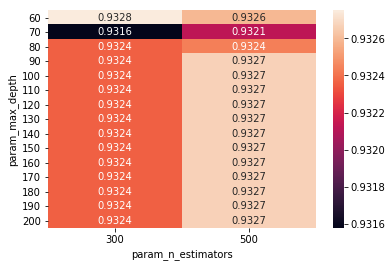

In [51]:
plot_search(grid_search2)

In [55]:
rfc = RandomForestClassifier(n_estimators=300, max_depth=160, criterion='entropy', random_state=42)
rfc.fit(X_train, y_train)
report(rfc)

Train Score: 
0.9994532531437944
Test Score: 
0.932536893886156
Confusion Matrix: 
[[875   0   7   0   0   0]
 [  1  18   2   0   0   0]
 [ 47   0 386   0   0   0]
 [  2   0   3   4   0   0]
 [ 19   0   7   0  18   0]
 [  4   0   3   0   1  26]]
Report: 
             precision    recall  f1-score   support

        0.0       0.92      0.99      0.96       882
        1.0       1.00      0.86      0.92        21
        2.0       0.95      0.89      0.92       433
        3.0       1.00      0.44      0.62         9
        4.0       0.95      0.41      0.57        44
        5.0       1.00      0.76      0.87        34

avg / total       0.93      0.93      0.93      1423



### part 5: MLP

In this part, I tried many other options for hidden layers (varying also the number of hidden layers) and looked at the validation data, but the two layer network below is the best

In [56]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
mlp = MLPClassifier(hidden_layer_sizes=(128, ))
print("Validation scores: ")
for train_indices, val_indices in kf.split(X_train):
    mlp.fit(X_train[train_indices], y_train[train_indices])
    print(mlp.score(X_train[val_indices], y_train[val_indices]))

Validation scores: 
0.9262007028504491
0.9246388129636861
0.9359625146427177
0.9359375
0.931640625


In [57]:
mlp.fit(X_train, y_train)
report(mlp)

Train Score: 
0.9994532531437944
Test Score: 
0.9297259311314126
Confusion Matrix: 
[[863   0  10   0   7   2]
 [  0  18   2   0   0   1]
 [ 35   1 391   0   4   2]
 [  1   1   2   4   1   0]
 [ 10   1   4   0  22   7]
 [  1   1   2   0   5  25]]
Report: 
             precision    recall  f1-score   support

        0.0       0.95      0.98      0.96       882
        1.0       0.82      0.86      0.84        21
        2.0       0.95      0.90      0.93       433
        3.0       1.00      0.44      0.62         9
        4.0       0.56      0.50      0.53        44
        5.0       0.68      0.74      0.70        34

avg / total       0.93      0.93      0.93      1423



## Variant lengths

### Part 6

In [ ]:
data = pd.DataFrame(columns=['substr', 'Structure'])
max_len = 15
min_len = 2

files = glob('../DSSP/*.dssp')
for f in files:
    df = pd.read_csv(f, delimiter=' ')
    structure = df['Structure']
    amino_acid = df['AA']
    idx = []  # list of indices
    cumsum = [0]
    for i in range(1, len(df)):
        cumsum.append(cumsum[i - 1] + 1 if structure[i] == structure[i - 1] else 0)

    for i in range(1, len(df)):
        if i == 1 or cumsum[i] == 0:
            str_len = cumsum[i - 1] + 1
            if min_len <= str_len <= max_len:
                idx.append(i - str_len)
                data = data.append({
                    'substr': (''.join(amino_acid[i - str_len: i]).zfill(max_len)),
                    'Structure': structure[i - 1]}, ignore_index=True)
    data.to_csv('data/var_raw.csv')

df = data.substr.str.split('', expand=True)
columns = df.columns.tolist()
cols_to_use = columns[1:len(columns) - 1]
df = df[cols_to_use]
df.columns = ['AA%d' % i for i in range(1, max_len + 1)]
df['label'] = data['Structure']
df = df.applymap(lambda s:s.upper() if type(s) == str else s)
df.to_csv('data/var.csv', index=False)
X, y = transform('var', max_len)

In [64]:
data = np.load('data/var_transformed.npy')
X, y = data[:, :-1], data[:, -1]
n_classes = len(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape

(292670, 365)

In [61]:
depths = [int(x) for x in np.linspace(60, 300, num = 15)]
depths.append(None)
n_estimators = [200]

grid_search = search(depths, n_estimators)

# did not have enough time and resouces to run on jupyter again but the optimal hyperparameters are set in final answer

In [68]:
rfc = RandomForestClassifier(n_estimators=200, max_depth=210, random_state=42)
rfc.fit(X_train, y_train)
report(rfc)

Train Score: 
0.8267195134451771
Test Score: 
0.7840954518896645
Confusion Matrix: 
[[   8   25    2    0    0   39  107]
 [   1 7390  124  123    1  318  683]
 [   0  123 2091   30    0  154  237]
 [   0  185   41 4786    3   41   66]
 [   0   26    2    8  215    3    6]
 [   3  340  301   43    0 2428 2501]
 [   0  243  381   55    2  804 8580]]
Report: 
             precision    recall  f1-score   support

        0.0       0.67      0.04      0.08       181
        1.0       0.89      0.86      0.87      8640
        2.0       0.71      0.79      0.75      2635
        3.0       0.95      0.93      0.94      5122
        4.0       0.97      0.83      0.89       260
        5.0       0.64      0.43      0.52      5616
        6.0       0.70      0.85      0.77     10065

avg / total       0.78      0.78      0.78     32519



In [66]:
mlp = MLPClassifier(hidden_layer_sizes=(256, 32, ), verbose=True)
mlp.fit(X_train, y_train)
report(mlp)

Iteration 1, loss = 0.88268215
Iteration 2, loss = 0.74568435
Iteration 3, loss = 0.69764084
Iteration 4, loss = 0.66704916
Iteration 5, loss = 0.64552313
Iteration 6, loss = 0.62856249
Iteration 7, loss = 0.61535405
Iteration 8, loss = 0.60419833
Iteration 9, loss = 0.59470846
Iteration 10, loss = 0.58690358
Iteration 11, loss = 0.57976353
Iteration 12, loss = 0.57328049
Iteration 13, loss = 0.56797417
Iteration 14, loss = 0.56245913
Iteration 15, loss = 0.55801983
Iteration 16, loss = 0.55342190
Iteration 17, loss = 0.54902503
Iteration 18, loss = 0.54537946
Iteration 19, loss = 0.54173637
Iteration 20, loss = 0.53865343
Iteration 21, loss = 0.53520421
Iteration 22, loss = 0.53217288
Iteration 23, loss = 0.52952283
Iteration 24, loss = 0.52717641
Iteration 25, loss = 0.52501507
Iteration 26, loss = 0.52235755
Iteration 27, loss = 0.51980240
Iteration 28, loss = 0.51810280
Iteration 29, loss = 0.51641224
Iteration 30, loss = 0.51412423
Iteration 31, loss = 0.51280566
Iteration 32, los

In [67]:
report(mlp)

Train Score: 
0.814586394232412
Test Score: 
0.7715796918724438
Confusion Matrix: 
[[   6   23    2    0    0   39  111]
 [   2 7159  122  169   15  382  791]
 [   0  116 1964   42    1  210  302]
 [   0  187   39 4729   16   68   83]
 [   0   22    5    7  211    7    8]
 [   1  266  280   62    9 2338 2660]
 [   2  173  337   62    4  803 8684]]
Report: 
             precision    recall  f1-score   support

        0.0       0.55      0.03      0.06       181
        1.0       0.90      0.83      0.86      8640
        2.0       0.71      0.75      0.73      2635
        3.0       0.93      0.92      0.93      5122
        4.0       0.82      0.81      0.82       260
        5.0       0.61      0.42      0.49      5616
        6.0       0.69      0.86      0.76     10065

avg / total       0.77      0.77      0.76     32519

